In [1]:
import sys; sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')
import pickle

from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path

from src.evaluation import nemenyi_critical_values

import matplotlib.pyplot as plt

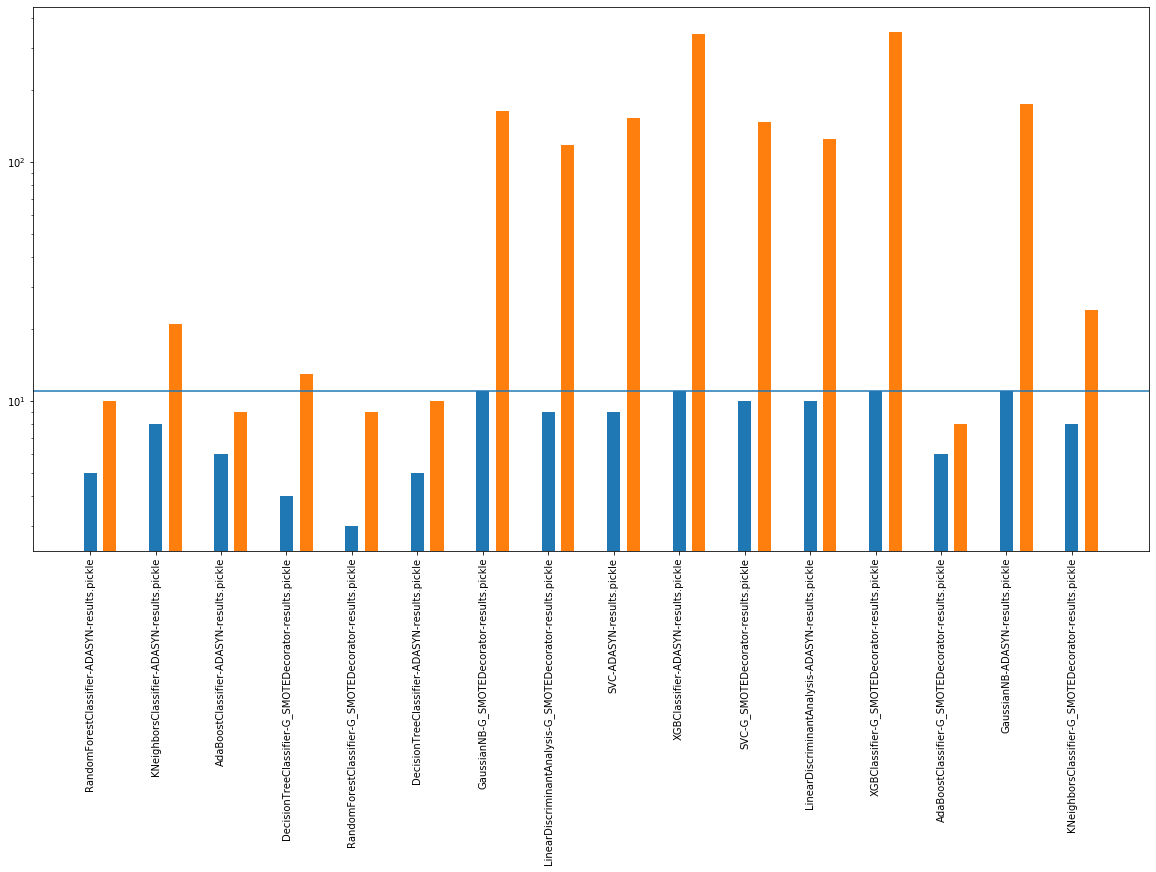

In [2]:
res_paths = glob('../experiments/feature_selection/results/*-results.pickle')

n_cols_plots = 3
n_rows_plots = (len(res_paths) // n_cols_plots) + 1

tps, ts, gts, labels = [], [], [], []
for i, path in enumerate(res_paths):
    path = Path(path)
    with open(path, 'rb') as fh:
        _, y_true, y_pred = pickle.load(fh)
    tps.append(sum(y_true & y_pred))
    ts.append(sum(y_pred))
    gts.append(sum(y_true))
    labels.append(path.name)

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=90)
plt.yscale('log')
plt.axhline(gts[0])

Text(0.5, 1.0, 'Number of features used')

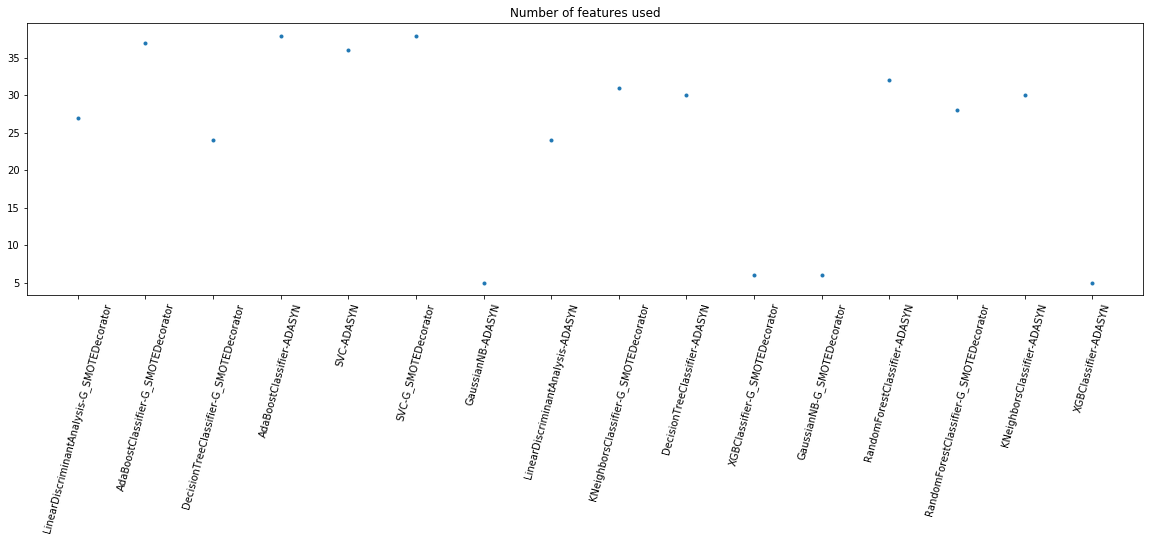

In [3]:
res_paths = glob('../experiments/feature_selection/results/*.pickle')
ns = []
labels = []

for i, path in enumerate(res_paths):
    path = Path(path)
    if 'results' in path.name: continue
    with open(path, 'rb') as fh:
        ns.append(pickle.load(fh)['FEATURE_SELECTION__k'])
        labels.append(path.name.rsplit('.', 1)[0])
plt.figure(figsize=(20, 5))
x = range(len(ns))
plt.scatter(x, ns, marker='.')
plt.xticks(x, labels, rotation=75)
plt.title('Number of features used')

In [4]:
res_paths = glob('../experiments/feature_selection/results/*.pickle')
test_scores = {}

for i, path in enumerate(res_paths):
    path = Path(path)
    if 'results' in path.name: continue
    with open(path, 'rb') as fh:
        conf = pickle.load(fh)
    with open(str(path).rsplit('.', 1)[0] + '-results.pickle', 'rb') as fh:
        results, *_ = pickle.load(fh)
    
    results = pd.DataFrame(results)
    scores = results[results.params == conf].filter(regex='split\d_test*').values
    if len(scores) != 0:
        test_scores[path.name.rsplit('.', 1)[0]] = scores[0]
    else:
        test_scores[path.name.rsplit('.', 1)[0]] =\
            results[results.params.apply(lambda d: d.get('AdaBoostClassifier__n_estimators', None)) == conf['AdaBoostClassifier__n_estimators']]\
                .filter(regex='split\d_test*').values[0]

In [5]:
new_test_scores = {}
explored_clfs = []

for key in test_scores:
    clf = key.split('-')[0]
    if not clf in explored_clfs:
        explored_clfs.append(clf)
        smote = test_scores[f'{clf}-G_SMOTEDecorator']
        adasyn = test_scores[f'{clf}-ADASYN']
        if np.mean(smote) > np.mean(adasyn):
            new_test_scores[f'{clf}-G_SMOTEDecorator'] = test_scores[f'{clf}-G_SMOTEDecorator']
        else:
            new_test_scores[f'{clf}-ADASYN'] = test_scores[f'{clf}-ADASYN']

test_scores = new_test_scores
test_scores = list(test_scores.items())
test_scores = sorted(test_scores, key = lambda l: l[1].mean(), reverse=True)

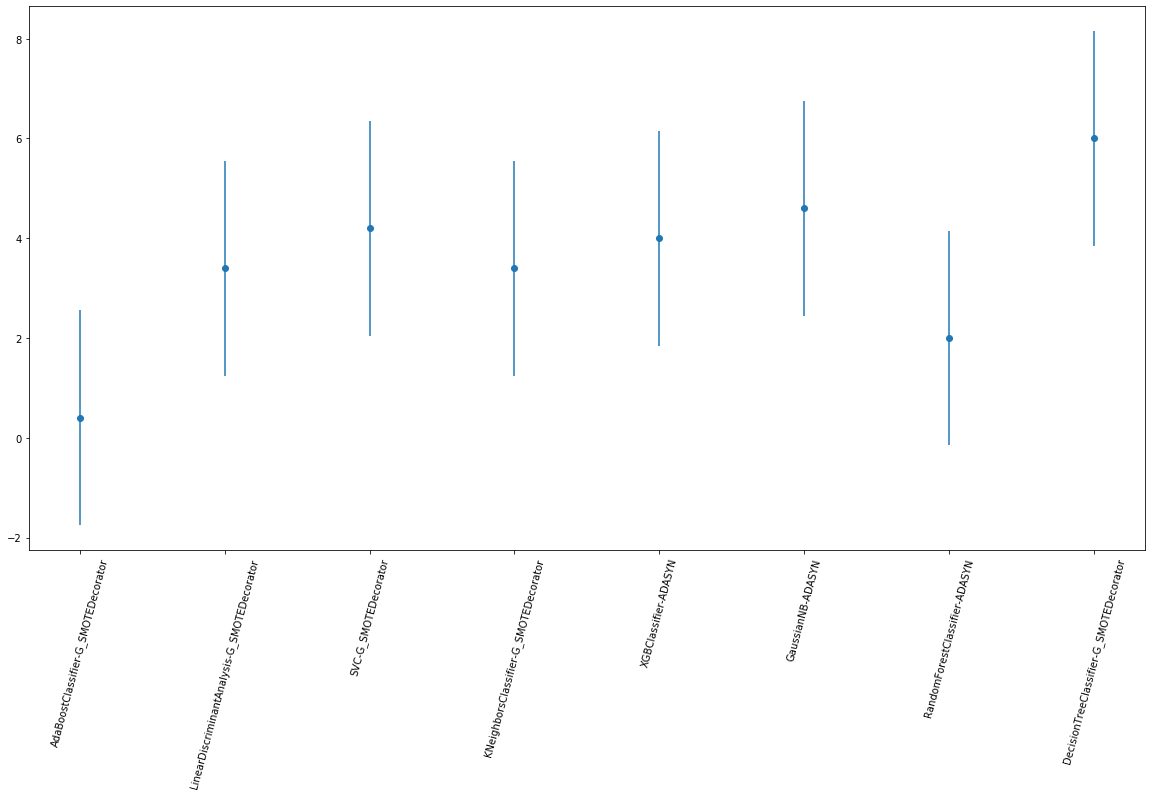

In [11]:
runs = pd.DataFrame(
    [run for _, run in test_scores],
    index=[alg for alg, _ in test_scores]
)

winners = pd.DataFrame(
    [np.argsort(-runs[i]) for i in runs.columns],
    columns=runs.index
).T


n_algs = len(winners)
cv = nemenyi_critical_values[n_algs].loc[0.1]
err = (cv * np.sqrt((n_algs * (n_algs + 1)) / (6 * len(winners.iloc[0])))) / 2
scores = pd.Series(
    [np.mean(e) for _, e in winners.iterrows()],
    index=runs.index
)

plt.figure(figsize=(20,10))
x = range(len(scores))
plt.errorbar(
    x, scores,
    yerr=err, fmt='o'
)
plt.xticks(x, winners.index, rotation=75)
pass